# Operator Learning - Convolutional Neural Operator

In **operator learning**, models are tasked with handling functions as inputs and outputs, which are stored on a computer in their **discrete representations** (e.g. images). They should have ability to process and generalize across various representations of the inputs, such as different mesh refinements.

Data-driven models that exhibit the mentioned properties are commonly known as ***Neural Operators***.

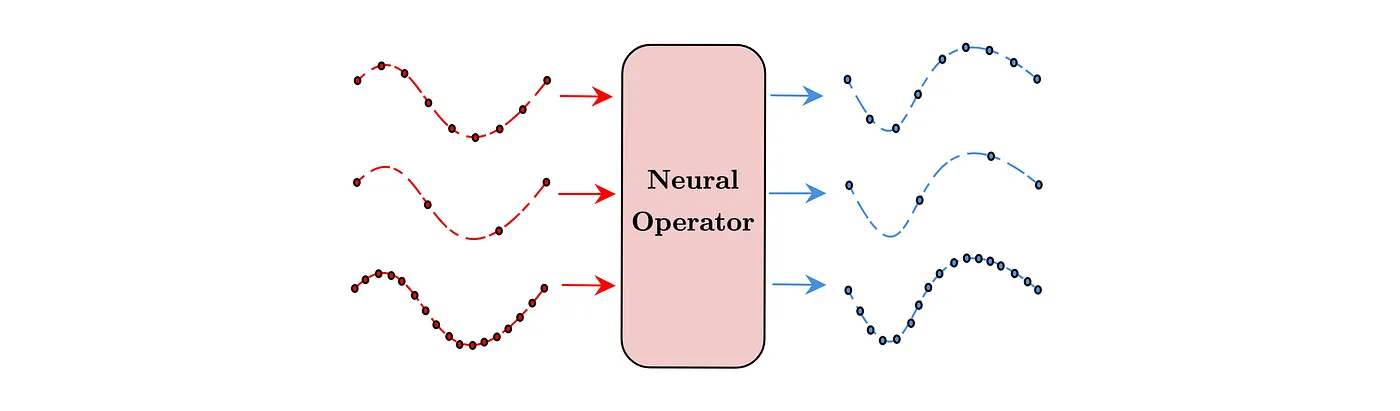



## Convolutional Neural Operator (CNO)

- Introduced in the paper [Convolutional Neural Operators for robust and accurate learning of PDEs
](https://arxiv.org/abs/2302.01178).
- CNO is formulated as an **iterative architecture**
- CNO uses **convolutions** parametrized in the **physical domain** (**local** operations)
- CNO uses U-Net like architecture for multi-scale learning
- CNO uses **skip connections** to enchance the training

First layer is the **lifting layer** (in the channel dimension, increases the number of channels), while the last layer is the **projection layer** (reduces the number of channels).


### You can read the CNO blog on [this link](https://medium.com/@bogdan.raonke/operator-learning-convolutional-neural-operators-for-robust-and-accurate-learning-of-pdes-ebbc43b57434).


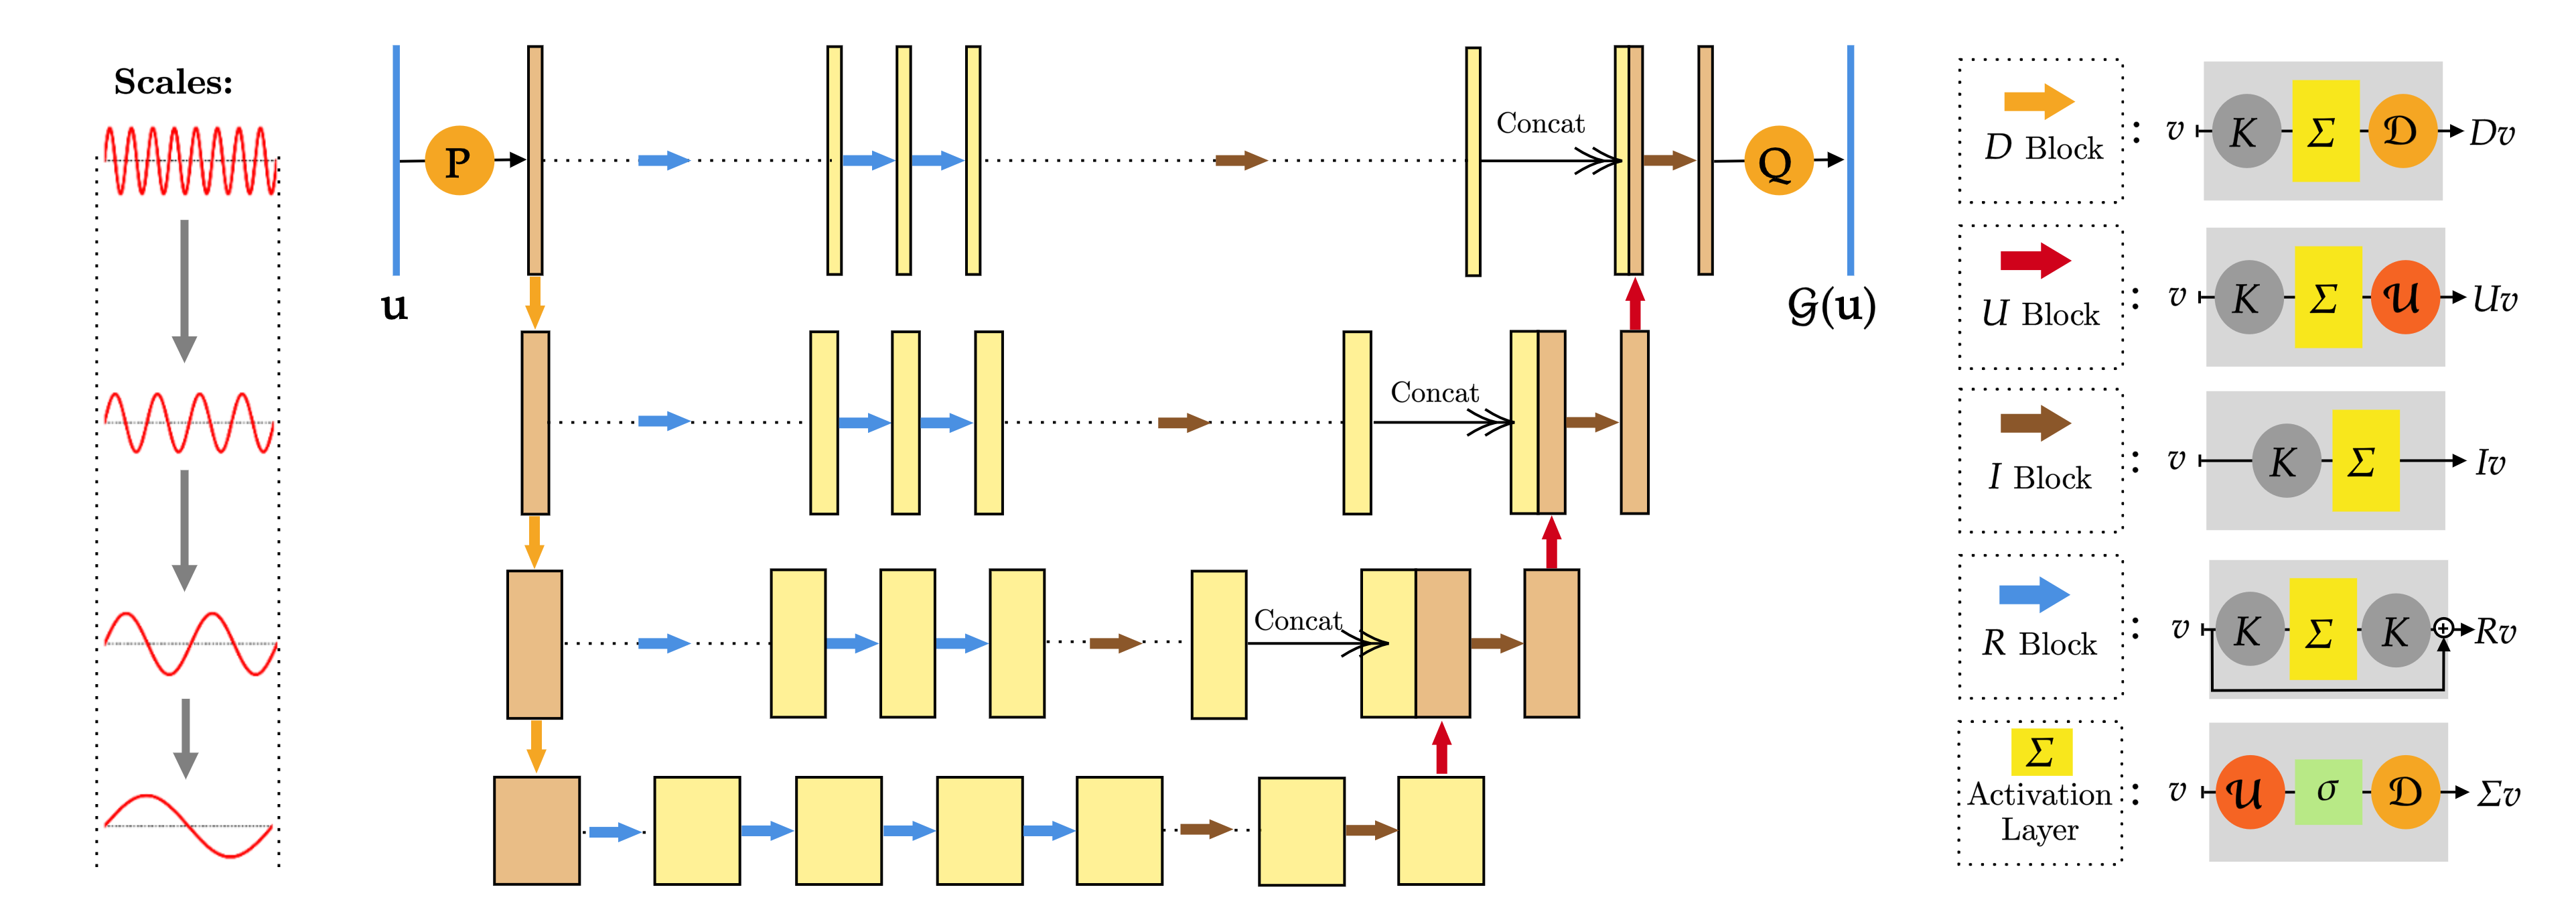

#### What is **aliasing** and why does it matter?

- Errors accumulate due to inconsistent frequency content
- Every fundamental operation creates additional aliasing errors that propagate through the

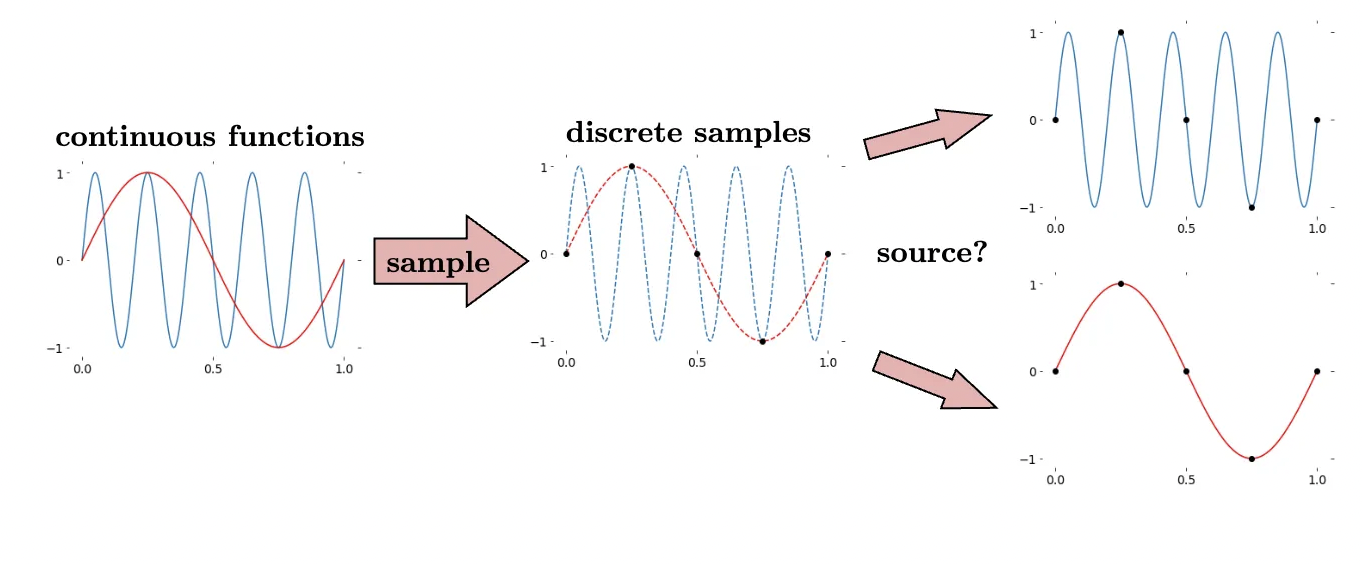

## How do the new operations work?

- Up/Downsampling uses filtering to get rid of aliasing

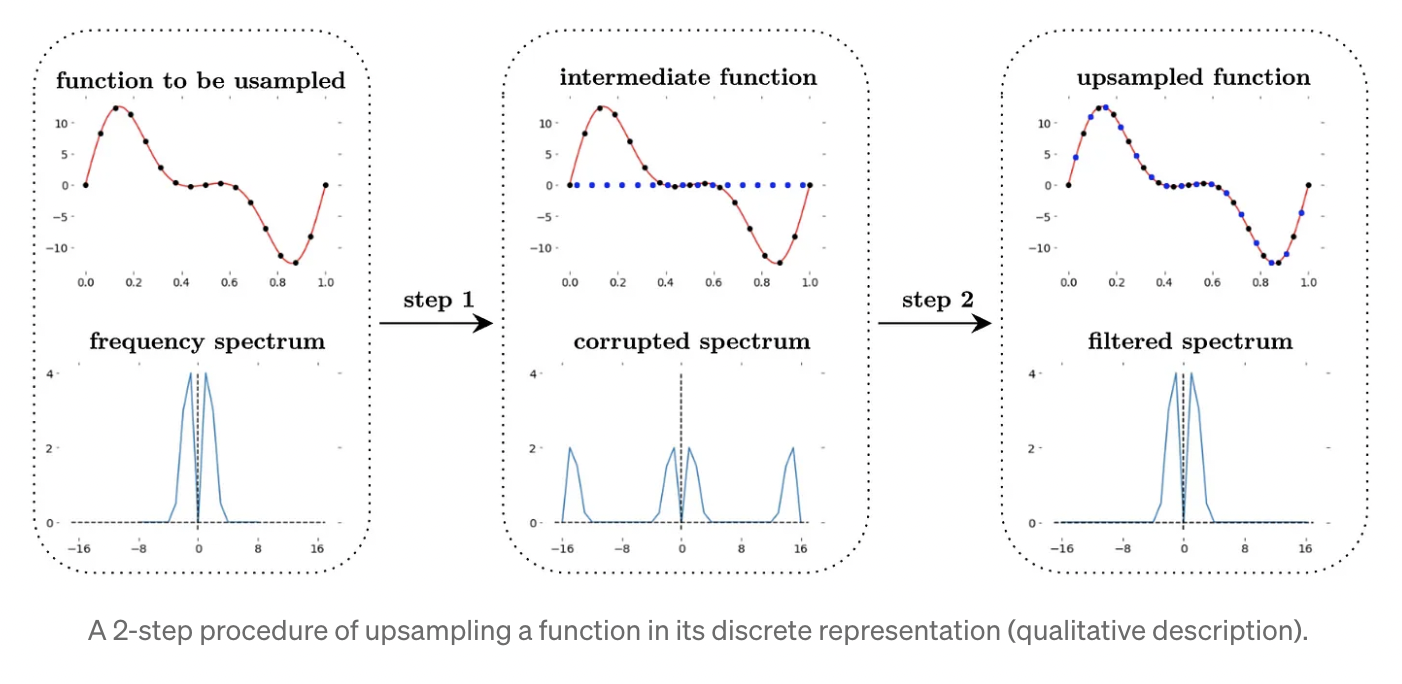

- Activation uses 3-step procedure to reduce aliasing errors

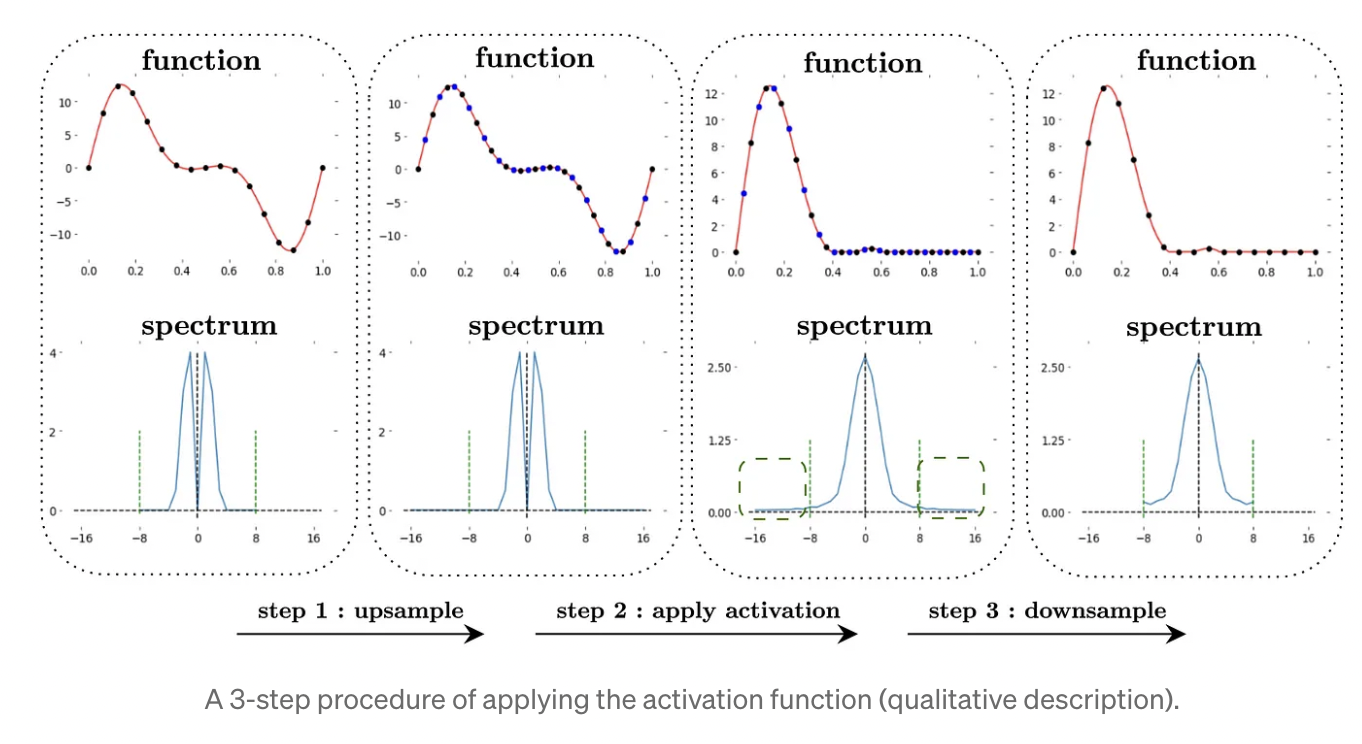

\\


## Implementation of CNO

- In the CNO paper implementation (2d model), we used CUDA to accelerate the application of 3-step activation function. Consequently, we were able to design our interpolation filters, which was handy for analyzing the impact of different filters (see [this github page](https://github.com/bogdanraonic3/ConvolutionalNeuralOperator/tree/main)).

- **In this notebook, we will implement 1d, pytorch version of the CNO model**.
- We will use **antialias interpoaltion** from the torch library.

In [ ]:
import torch
import torch.nn as nn
import os
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from torch.optim import AdamW
import matplotlib.pyplot as plt

In the following code, we will define
* **CNO LReLu** activation fucntion
* **CNO building block** (CNOBlock) → Conv1d - BatchNorm - Activation
* **Lift/Project Block** (Important for embeddings)
* **Residual Block** → Conv1d - BatchNorm - Activation - Conv1d - BatchNorm - *Skip Connection*
* **ResNet** → Stacked ResidualBlocks (several blocks applied iteratively)

In [ ]:
#---------------------
# Activation Function:
#---------------------

class CNO_LReLu(nn.Module):
    def __init__(self,
                 in_size,
                 out_size
                 ):
        super(CNO_LReLu, self).__init__()

        self.in_size = in_size
        self.out_size = out_size
        self.act = nn.LeakyReLU()

    def forward(self, x):

      x = F.interpolate(x.unsqueeze(2), size = (1,2 * self.in_size), mode = "bicubic", antialias = True)
      x = self.act(x)
      x = F.interpolate(x, size = (1,self.out_size), mode = "bicubic", antialias = True)

      return x[:,:,0]

#--------------------
# CNO Block:
#--------------------

class CNOBlock(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 in_size,
                 out_size,
                 use_bn = True
                 ):
        super(CNOBlock, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.in_size  = in_size
        self.out_size = out_size

        #-----------------------------------------

        # We apply Conv -> BN (optional) -> Activation
        # Up/Downsampling happens inside Activation

        self.convolution = torch.nn.Conv1d(in_channels = self.in_channels,
                                           out_channels= self.out_channels,
                                           kernel_size = 3,
                                           padding     = 1)

        if use_bn:
          self.batch_norm  = nn.BatchNorm1d(self.out_channels)
        else:
          self.batch_norm  = nn.Identity()
        self.act           = CNO_LReLu(in_size  = self.in_size,
                                       out_size = self.out_size)


    def forward(self, x):
        x = self.convolution(x)
        x = self.batch_norm(x)
        return self.act(x)

#--------------------
# Lift/Project Block:
#--------------------

class LiftProjectBlock(nn.Module):
    def __init__(self,
                in_channels,
                out_channels,
                size,
                latent_dim = 64
                ):
        super(LiftProjectBlock, self).__init__()

        self.inter_CNOBlock = CNOBlock(in_channels       = in_channels,
                                        out_channels     = latent_dim,
                                        in_size          = size,
                                        out_size         = size,
                                        use_bn           = False)

        self.convolution = torch.nn.Conv1d(in_channels  = latent_dim,
                                           out_channels = out_channels,
                                           kernel_size  = 3,
                                           padding      = 1)


    def forward(self, x):
        x = self.inter_CNOBlock(x)
        x = self.convolution(x)
        return x

#--------------------
# Residual Block:
#--------------------

class ResidualBlock(nn.Module):
    def __init__(self,
                 channels,
                 size,
                 use_bn = True
                 ):
        super(ResidualBlock, self).__init__()

        self.channels = channels
        self.size     = size

        #-----------------------------------------

        # We apply Conv -> BN (optional) -> Activation -> Conv -> BN (optional) -> Skip Connection
        # Up/Downsampling happens inside Activation

        self.convolution1 = torch.nn.Conv1d(in_channels = self.channels,
                                            out_channels= self.channels,
                                            kernel_size = 3,
                                            padding     = 1)
        self.convolution2 = torch.nn.Conv1d(in_channels = self.channels,
                                            out_channels= self.channels,
                                            kernel_size = 3,
                                            padding     = 1)

        if use_bn:
          self.batch_norm1  = nn.BatchNorm1d(self.channels)
          self.batch_norm2  = nn.BatchNorm1d(self.channels)

        else:
          self.batch_norm1  = nn.Identity()
          self.batch_norm2  = nn.Identity()

        self.act           = CNO_LReLu(in_size  = self.size,
                                       out_size = self.size)


    def forward(self, x):
        out = self.convolution1(x)
        out = self.batch_norm1(out)
        out = self.act(out)
        out = self.convolution2(out)
        out = self.batch_norm2(out)
        return x + out

#--------------------
# ResNet:
#--------------------

class ResNet(nn.Module):
    def __init__(self,
                 channels,
                 size,
                 num_blocks,
                 use_bn = True
                 ):
        super(ResNet, self).__init__()

        self.channels = channels
        self.size = size
        self.num_blocks = num_blocks

        self.res_nets = []
        for _ in range(self.num_blocks):
            self.res_nets.append(ResidualBlock(channels = channels,
                                              size = size,
                                              use_bn = use_bn))

        self.res_nets = torch.nn.Sequential(*self.res_nets)

    def forward(self, x):
        for i in range(self.num_blocks):
            x = self.res_nets[i](x)
        return x


In [ ]:
X = torch.rand((1,2,128))

#-------------
# Check your activation
#-------------
cno_lrelu = CNO_LReLu(in_size  = 128,
                      out_size = 128)
Y = cno_lrelu(X)
assert tuple(Y.shape) == (1,2,128)

#-------------
# Check your CNOBlock
#-------------
cno_block = CNOBlock(in_channels = 2,
                    out_channels = 4,
                    in_size = 128,
                    out_size = 64,
                    use_bn = True)
Y = cno_block(X)
assert tuple(Y.shape) == (1,4,64)

#-------------
# Check your LiftProjectBlock
#-------------
lift_project = LiftProjectBlock(in_channels = 2,
                                out_channels = 4,
                                size = 128)
Y = lift_project(X)
assert tuple(Y.shape) == (1,4,128)

#-------------
# Check your ResidualBlock
#-------------
residual_bl = ResidualBlock(channels = 2,
                            size = 128,
                            use_bn = True)
Y = residual_bl(X)
assert tuple(Y.shape) == (1,2,128)

#-------------
# Check your ResNet
#-------------
res_net = ResNet(channels = 2,
                 size = 128,
                 num_blocks = 3,
                 use_bn = True)
Y = res_net(X)
assert tuple(Y.shape) == (1,2,128)

####Once that all the CNO ingredients are implemented, we can code the **CNO model**
- CNO model has a UNet like architecture with additional ResNets that connect corresponding levels of the **encoder** and the **decoder**
- As in the case of FNO, there are **lifting** and **projection** layers.
- We assume that the input and the output sizes are equal, although, one can easily generalize to different sizes.

In [ ]:
#--------------------
# CNO:
#--------------------

class CNO1d(nn.Module):
    def __init__(self,
                 in_dim,                    # Number of input channels.
                 out_dim,                   # Number of input channels.
                 size,                      # Input and Output spatial size (required )
                 N_layers,                  # Number of (D) or (U) blocks in the network
                 N_res = 4,                 # Number of (R) blocks per level (except the neck)
                 N_res_neck = 4,            # Number of (R) blocks in the neck
                 channel_multiplier = 16,   # How the number of channels evolve?
                 use_bn = True,             # Add BN? We do not add BN in lifting/projection layer
                ):

        super(CNO1d, self).__init__()

        self.N_layers = int(N_layers)         # Number od (D) & (U) Blocks
        self.lift_dim = channel_multiplier//2 # Input is lifted to the half of channel_multiplier dimension
        self.in_dim   = in_dim
        self.out_dim  = out_dim
        self.channel_multiplier = channel_multiplier  # The growth of the channels

        ######## Num of channels/features - evolution ########

        self.encoder_features = [self.lift_dim] # How the features in Encoder evolve (number of features)
        for i in range(self.N_layers):
            self.encoder_features.append(2 ** i *   self.channel_multiplier)

        self.decoder_features_in = self.encoder_features[1:] # How the features in Decoder evolve (number of features)
        self.decoder_features_in.reverse()
        self.decoder_features_out = self.encoder_features[:-1]
        self.decoder_features_out.reverse()

        for i in range(1, self.N_layers):
            self.decoder_features_in[i] = 2*self.decoder_features_in[i] #Pad the outputs of the resnets (we must multiply by 2 then)

        ######## Spatial sizes of channels - evolution ########

        self.encoder_sizes = []
        self.decoder_sizes = []
        for i in range(self.N_layers + 1):
            self.encoder_sizes.append(size // 2 ** i)
            self.decoder_sizes.append(size // 2 ** (self.N_layers - i))


        ######## Define Lift and Project blocks ########

        self.lift   = LiftProjectBlock(in_channels = in_dim,
                                      out_channels = self.encoder_features[0],
                                      size = size)

        self.project   = LiftProjectBlock(in_channels = self.encoder_features[0] + self.decoder_features_out[-1],
                                          out_channels = out_dim,
                                          size = size)

        ######## Define Encoder, ED Linker and Decoder networks ########

        self.encoder         = nn.ModuleList([(CNOBlock(in_channels  = self.encoder_features[i],
                                                        out_channels = self.encoder_features[i+1],
                                                        in_size      = self.encoder_sizes[i],
                                                        out_size     = self.encoder_sizes[i+1],
                                                        use_bn       = use_bn))
                                               for i in range(self.N_layers)])

        # After the ResNets are executed, the sizes of encoder and decoder might not match (if out_size>1)
        # We must ensure that the sizes are the same, by aplying CNO Blocks
        self.ED_expansion     = nn.ModuleList([(CNOBlock(in_channels = self.encoder_features[i],
                                                        out_channels = self.encoder_features[i],
                                                        in_size      = self.encoder_sizes[i],
                                                        out_size     = self.decoder_sizes[self.N_layers - i],
                                                        use_bn       = use_bn))
                                               for i in range(self.N_layers + 1)])

        self.decoder         = nn.ModuleList([(CNOBlock(in_channels  = self.decoder_features_in[i],
                                                        out_channels = self.decoder_features_out[i],
                                                        in_size      = self.decoder_sizes[i],
                                                        out_size     = self.decoder_sizes[i+1],
                                                        use_bn       = use_bn))
                                               for i in range(self.N_layers)])

        ####################### Define ResNets Blocks ################################################################

        # Here, we define ResNet Blocks.

        # Operator UNet:
        # Outputs of the middle networks are patched (or padded) to corresponding sets of feature maps in the decoder

        self.res_nets = []
        self.N_res = int(N_res)
        self.N_res_neck = int(N_res_neck)

        # Define the ResNet networks (before the neck)
        for l in range(self.N_layers):
              self.res_nets.append(ResNet(channels = self.encoder_features[l],
                                          size = self.encoder_sizes[l],
                                          num_blocks = self.N_res,
                                          use_bn = use_bn))

        self.res_net_neck = ResNet(channels = self.encoder_features[self.N_layers],
                                  size = self.encoder_sizes[self.N_layers],
                                  num_blocks = self.N_res_neck,
                                  use_bn = use_bn)

        self.res_nets = torch.nn.Sequential(*self.res_nets)

    def forward(self, x):

      x = self.lift(x) #Execute Lift
      skip = []

      # Execute Encoder
      for i in range(self.N_layers):

          #Apply ResNet & save the result
          y = self.res_nets[i](x)
          skip.append(y)

          # Apply (D) block
          x = self.encoder[i](x)


      # Apply the deepest ResNet (bottle neck)
      x = self.res_net_neck(x)

      # Execute Decode
      for i in range(self.N_layers):

          # Apply (I) block (ED_expansion) & cat if needed
          if i == 0:
              x = self.ED_expansion[self.N_layers - i](x) #BottleNeck : no cat
          else:
              x = torch.cat((x, self.ED_expansion[self.N_layers - i](skip[-i])),1)

          # Apply (U) block
          x = self.decoder[i](x)

      # Cat & Execute Projetion
      x = torch.cat((x, self.ED_expansion[0](skip[0])),1)
      x = self.project(x)

      return x


## Example

We will solve Allen-Cahn equation:

## $u_t = \Delta u - ϵ^2 u (u^2 - 1),\quad u\in\mathbb{R}×\mathbb{R_{>0}}$

Operator that we wish to learn is

## $\mathcal{G}: u(\cdot, t = 0) \mapsto  u(\cdot, t = 1)$

Note that the data is generated for you (see the files *AC_data_input.npy* and *AC_data_output.npy*).

In [ ]:
torch.manual_seed(0)
np.random.seed(0)

In [ ]:
n_train = 100 # number of training samples

# Load the data
# - AC_data_input.npy
# - AC_data_output.npy

# We will decrease the resolution to s = 256, for more convenient training

x_data = torch.from_numpy(np.load("AC_data_input.npy")).type(torch.float32)
y_data = torch.from_numpy(np.load("AC_data_output.npy")).type(torch.float32)

x_data = x_data.permute(0,2,1)
y_data = y_data.unsqueeze(1)
s = 256
x_data = F.interpolate(x_data.unsqueeze(2), size = (1, s), mode = "bicubic")[:,:,0]
y_data = F.interpolate(y_data.unsqueeze(2), size = (1, s), mode = "bicubic")[:,:,0]


input_function_train = x_data[:n_train, :]
output_function_train = y_data[:n_train, :]
input_function_test = x_data[n_train:, :]
output_function_test = y_data[n_train:, :]

batch_size = 10

training_set = DataLoader(TensorDataset(input_function_train, output_function_train), batch_size=batch_size, shuffle=True)
testing_set = DataLoader(TensorDataset(input_function_test, output_function_test), batch_size=batch_size, shuffle=False)

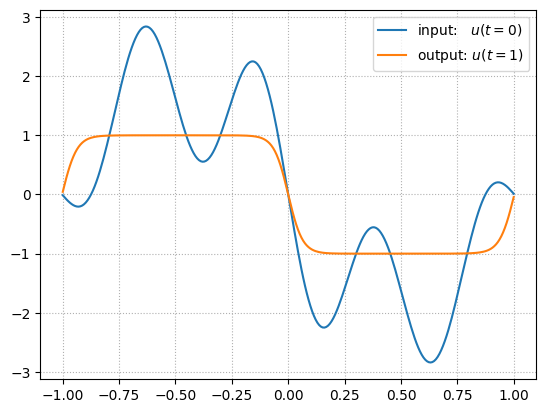

In [ ]:
id_sample = 32

plt.plot(np.linspace(-1,1,s),input_function_train[id_sample,1,:], label = "input:   $u(t = 0)$")
plt.plot(np.linspace(-1,1,s),output_function_train[id_sample, 0,:], label = "output: $u(t = 1)$")
plt.grid(True, which="both", ls=":")
plt.legend()

In [ ]:
learning_rate = 0.001
epochs = 50
step_size = 15
gamma = 0.5

In [ ]:
N_layers = 4
N_res    = 4
N_res_neck = 4
channel_multiplier = 16

cno = CNO1d(in_dim = 2,                                    # Number of input channels.
            out_dim = 1,                                   # Number of input channels.
            size = s,                                      # Input and Output spatial size (required )
            N_layers = N_layers,                           # Number of (D) or (U) blocks in the network
            N_res = N_res,                                 # Number of (R) blocks per level (except the neck)
            N_res_neck = N_res_neck,                       # Number of (R) blocks in the neck
            channel_multiplier = channel_multiplier,       # How the number of channels evolve?
            use_bn = False)


## Training

In [ ]:
optimizer = AdamW(cno.parameters(), lr=learning_rate, weight_decay=1e-8)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

l = nn.L1Loss()
freq_print = 1
for epoch in range(epochs):
    train_mse = 0.0
    for step, (input_batch, output_batch) in enumerate(training_set):
        optimizer.zero_grad()
        output_pred_batch = cno(input_batch)
        loss_f = l(output_pred_batch, output_batch)
        loss_f.backward()
        optimizer.step()
        train_mse += loss_f.item()
    train_mse /= len(training_set)

    scheduler.step()

    with torch.no_grad():
        cno.eval()
        test_relative_l2 = 0.0
        for step, (input_batch, output_batch) in enumerate(testing_set):
            output_pred_batch = cno(input_batch)
            loss_f = (torch.mean((abs(output_pred_batch - output_batch))) / torch.mean(abs(output_batch))) ** 0.5 * 100
            test_relative_l2 += loss_f.item()
        test_relative_l2 /= len(testing_set)

    if epoch % freq_print == 0: print("######### Epoch:", epoch, " ######### Train Loss:", train_mse, " ######### Relative L1 Test Norm:", test_relative_l2)



######### Epoch: 0  ######### Train Loss: 0.7422390162944794  ######### Relative L1 Test Norm: 87.14499732123481
######### Epoch: 1  ######### Train Loss: 0.475136798620224  ######### Relative L1 Test Norm: 60.93555708991157
######### Epoch: 2  ######### Train Loss: 0.2679743513464928  ######### Relative L1 Test Norm: 51.439714982774525
######### Epoch: 3  ######### Train Loss: 0.2007274881005287  ######### Relative L1 Test Norm: 46.83994598388672
######### Epoch: 4  ######### Train Loss: 0.17458614483475685  ######### Relative L1 Test Norm: 44.65487480163574
######### Epoch: 5  ######### Train Loss: 0.1537809267640114  ######### Relative L1 Test Norm: 40.97825944688585
######### Epoch: 6  ######### Train Loss: 0.15609129071235656  ######### Relative L1 Test Norm: 40.55288916693793
######### Epoch: 7  ######### Train Loss: 0.1478300392627716  ######### Relative L1 Test Norm: 42.07238930596246
######### Epoch: 8  ######### Train Loss: 0.13552724346518516  ######### Relative L1 Test Norm

## Plot

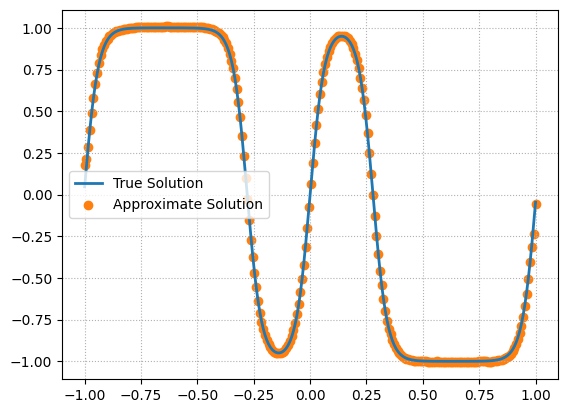

In [ ]:
idx_data = 32
input_function_test_n = input_function_test[idx_data].unsqueeze(0)
output_function_test_n = output_function_test[idx_data].unsqueeze(0)
output_function_test_pred_n = cno(input_function_test_n)

plt.figure()
plt.grid(True, which="both", ls=":")
X = np.linspace(-1,1,s)
plt.plot(X,output_function_test_n[0,0].detach(), label="True Solution", c="C0", lw=2)
plt.scatter(X,output_function_test_pred_n[0,0].detach(), label="Approximate Solution", c="C1")
p = 1
plt.legend()

\\

## TO DO at home:
- Run training for more than 100 epochs to see what happens
- Vary the CNO hyperparameters to see the impact
- Change the *interpolation mode* in the definition of activation function to see the impact

### Official CNO2d repo can be found [here](https://github.com/bogdanraonic3/ConvolutionalNeuralOperator/tree/main)
